In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import scipy.ndimage
import geopandas as gpd
import shapely.geometry as geom
import matplotlib.patches as mpatches

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 18

%matplotlib notebook

# Overview

This notebook provides an overview of the datasets and context for visualizing and analyzing the spatiotemporal impact of the **2018 California wildfires** on respiratory outcomes. Specifically, we focus on PM2.5 levels and county-level respiratory illness hospitalizations during the event window of interest.

## Data Sources

- **Features, PM2.5, and Hospitalizations**  
  - Acquired from the study: [Applying a two-stage generalized synthetic control approach to quantify the heterogeneous health effects of extreme weather events: A 2018 large wildfire in California event as a case study](https://pmc.ncbi.nlm.nih.gov/articles/PMC11692959).  
  - The relevant data files and scripts are hosted in their GitHub repository:  
    [benmarhnia-lab/Wildfires_social_vulnerability](https://github.com/benmarhnia-lab/Wildfires_social_vulnerability).

- **County Data**  
  - Obtained from the Fresno County Public Library resource:  
    [https://www.fresnolibrary.org/ref/pop/caldof.html](https://www.fresnolibrary.org/ref/pop/caldof.html).

## Event Details: 2018 California Wildfires

- **Data Period**: January 1 to December 31, 2018  
- **Exposure Window (Camp Fire)**: November 8 to December 5, 2018  

The 2018 California wildfires were a series of catastrophic fires across the state, significantly impacting air quality and public health. Among these, the **Camp Fire** (November 2018) was one of the most destructive in California’s recorded history, prompting extensive study into its health impacts. For additional background, see:  [Wikipedia: 2018 California Wildfires](https://en.wikipedia.org/wiki/2018_California_wildfires).

---

**Note**: In this notebook, we will integrate these data sources to visualize trends and explore relationships between wildfire smoke exposure (PM2.5) and respiratory health outcomes across different California counties. This context is crucial for understanding how large-scale environmental hazards can have heterogeneous effects on public health.


In [2]:
# Figure directory
figs_dir = "./data/wildfire/figures"
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)

# 1. Process Data

In [3]:
data_folder = "./data/wildfire"
processed_folder = "./data/wildfire/processed_data"
data_name = "CA_hosp_County_2018.csv"
pop_name = "CA_population.csv"
data = pd.read_csv(os.path.join(data_folder, data_name))
pop = pd.read_csv(os.path.join(data_folder, pop_name))
pop["Population"] = pop['Population'].str.replace(',', '').astype(int)
pop.rename(columns = {"Population": "pop"}, inplace=True)

In [4]:
data = data.merge(pop, left_on="countyname", right_on="County").drop(columns=["County", "COUNTY_1", "week2"])
data["resp_norm"] = (data["resp"] / data["pop"]) * 10000 # Cases per 10000

In [5]:
data.head()

,year,month,day,countyname,smoke,tmax,prec,hum,shrtwv_rad,wind,circ,resp,week,pop,resp_norm
0,2018,1,1,Alameda,0.0,288.816981,0.286792,0.005750,83.581132,1.347170,248,762,53,1666756,4.571755
1,2018,1,2,Alameda,0.0,288.869811,0.700000,0.005500,89.958491,1.118868,226,735,53,1666756,4.409764
2,2018,1,3,Alameda,0.0,287.347170,9.733962,0.006718,42.496226,2.183019,222,696,53,1666756,4.175776
3,2018,1,4,Alameda,0.0,291.532075,1.698113,0.008416,44.624528,3.441509,231,666,1,1666756,3.995786
4,2018,1,5,Alameda,0.0,289.747170,6.266038,0.008744,34.845283,2.113208,259,773,1,1666756,4.637751


# 2. Data Visualizations

## 2.1 PM2.5 Levels During Active Wildfires (May-Dec 2008)

In [6]:
data_slice = data[(data.year==2018) & (data.week >= 20) & (data.week <= 48)].reset_index(drop=True)

In [7]:
data_slice['day_of_year'] = pd.to_datetime(data_slice[['year', 'month', 'day']]).dt.dayofyear

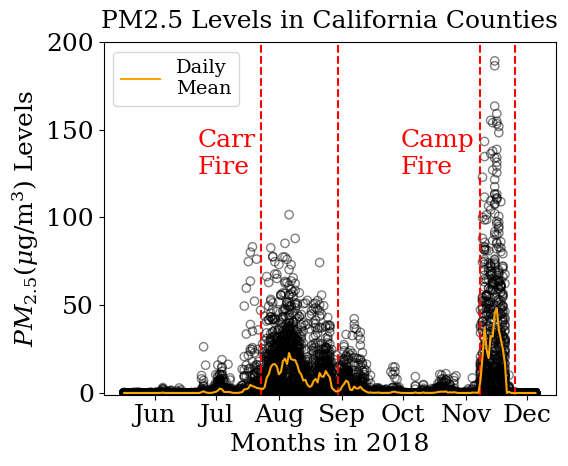

In [8]:
%matplotlib inline
plt.figure(figsize=(6, 5))
smoke_df = data_slice.groupby("day_of_year").agg({"smoke":"mean", "month":"max"}).reset_index()
plt.plot(smoke_df["day_of_year"], smoke_df["smoke"], zorder=10, color='orange', label="Daily\nMean")
plt.scatter(data_slice.day_of_year, data_slice.smoke, facecolors='none', edgecolors='black', alpha=0.5, zorder=1)
plt.xticks([152, 182, 213,  244,  274, 305, 335], ["Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.ylim(-1, 200)
plt.axvline(204, color='red', linestyle='--')
plt.axvline(242, color='red', linestyle='--')
plt.text(x=173, y=125, s="Carr\nFire", color='red')
plt.axvline(312, color='red', linestyle='--')
plt.axvline(329, color='red', linestyle='--')
plt.text(x=273, y=125, s="Camp\nFire", color='red')
plt.xlabel("Months in 2018", fontsize=18)
plt.ylabel(r"$PM_{2.5}(\mu \mathrm{g}/\mathrm{m}^3)$ Levels", fontsize=18)
plt.title("PM2.5 Levels in California Counties", fontsize=18, pad=10)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(figs_dir, "PM2.5_vs_month.pdf"), dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(figs_dir, "PM2.5_vs_month.png"), dpi=200, bbox_inches="tight")
plt.show()

## 2.2 Average Respiratory Illness Hospitalization Rates 

* By day and week

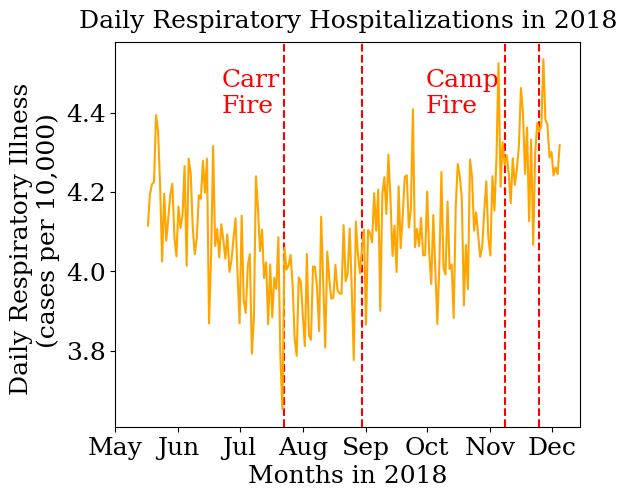

In [9]:
%matplotlib inline
smoke_df = data_slice.groupby("day_of_year").agg({"resp":"sum", "pop":"sum", "month":"max"}).reset_index()
plt.figure(figsize=(6, 5))
plt.plot(smoke_df["day_of_year"], smoke_df["resp"]/smoke_df["pop"]*10000, zorder=10, color='orange')
plt.xticks([121, 152, 182, 213,  244,  274, 305, 335], ["May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.axvline(204, color='red', linestyle='--')
plt.axvline(242, color='red', linestyle='--')
plt.axvline(312, color='red', linestyle='--')
plt.axvline(329, color='red', linestyle='--')
plt.text(x=173, y=4.4, s="Carr\nFire", color='red')
plt.text(x=273, y=4.4, s="Camp\nFire", color='red')
plt.xlabel("Months in 2018")
plt.ylabel("Daily Respiratory Illness \n (cases per 10,000)")
plt.title("Daily Respiratory Hospitalizations in 2018", pad=10, fontsize=18)

plt.savefig(os.path.join(figs_dir, "Resp_rate_vs_day.pdf"), dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(figs_dir, "Resp_rate_vs_day.png"), dpi=200, bbox_inches="tight")
plt.show()

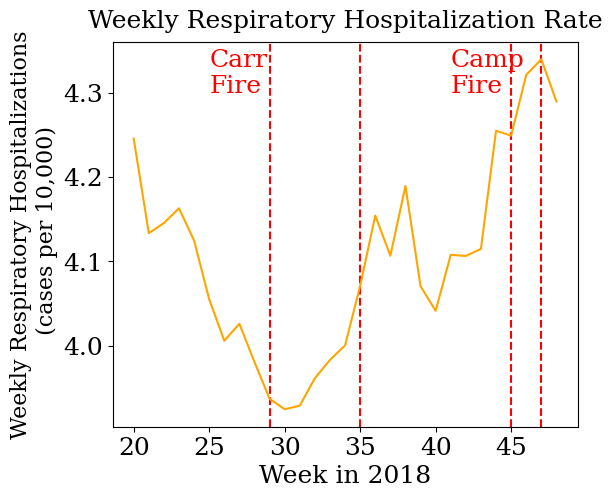

In [10]:
%matplotlib inline
smoke_df = data_slice.groupby("week").agg({"resp":"sum", "pop":"sum", "month":"max"}).reset_index()
plt.figure(figsize=(6, 5))
plt.plot(smoke_df["week"], smoke_df["resp"]/smoke_df["pop"]*10000, zorder=10, color='orange')
plt.axvline(29, color='red', linestyle='--')
plt.axvline(35, color='red', linestyle='--')
plt.text(x=25, y=4.3, s="Carr\nFire", color='red')
plt.axvline(45, color='red', linestyle='--')
plt.axvline(47, color='red', linestyle='--')
plt.text(x=41, y=4.3, s="Camp\nFire", color='red')
plt.xlabel("Week in 2018")
plt.xticks([20, 25, 30, 35, 40, 45], [20, 25, 30, 35, 40, 45])
plt.ylabel("Weekly Respiratory Hospitalizations\n (cases per 10,000)", fontsize=16)
plt.title("Weekly Respiratory Hospitalization Rate", pad=10, fontsize=18)

plt.savefig(os.path.join(figs_dir, "Resp_rate_vs_week.pdf"), dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(figs_dir, "Resp_rate_vs_week.png"), dpi=200, bbox_inches="tight")
plt.show()

## 2.3 Camp Fire Exposure Maps

* "Exposure" is defined as having an average PM2.5 larger than $10\;\mu \text{g}/\text{m}^3$ during the exposure window. 

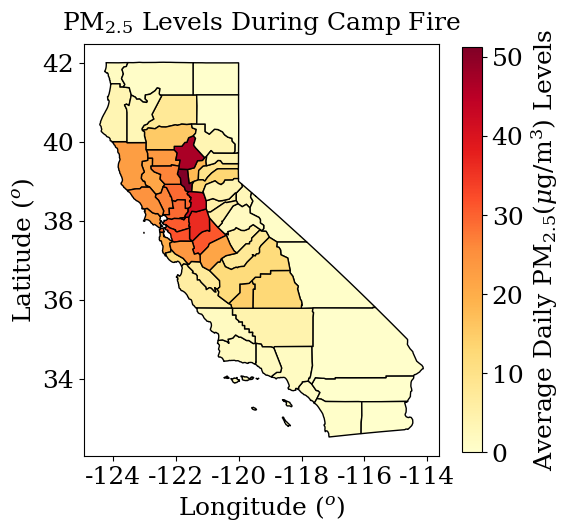

In [11]:
### Make exposed counties map
# Load a GeoDataFrame of US counties

%matplotlib inline
exposed_data = data_slice[(data_slice.day_of_year>=312) & (data_slice.day_of_year<340)]
exposed_data = exposed_data.groupby("countyname").agg({"smoke": "mean"}).reset_index()

url = "https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json"
counties = gpd.read_file(url)

# Filter counties to only include those in California (FIPS code '06')
counties['state'] = counties['id'].str[:2]  # Extract state FIPS code
california_counties = counties[counties['state'] == '06'].reset_index()

california_counties = california_counties.merge(exposed_data[["countyname", "smoke"]], left_on="NAME", right_on="countyname")

# Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(1, 1, figsize=(6, 6))

im1 = california_counties.plot(
    column="smoke",
    ax=axes,
    edgecolor='black',
    cmap='YlOrRd', 
    vmin=0,
    vmax=california_counties.smoke.max())

axes.set_title(r"PM$_{2.5}$ Levels During Camp Fire", fontsize=18, pad=10)
cbar1 = fig.colorbar(axes.collections[0], ax=axes, shrink=0.85)
cbar1.set_label(r"Average Daily PM$_{2.5}(\mu \mathrm{g}/\mathrm{m}^3)$ Levels", fontsize=18)

plt.xlabel(r"Longitude ($^o$)")
plt.ylabel(r"Latitude ($^o$)")
plt.xticks([-124, -122, -120, -118, -116, -114], [-124, -122, -120, -118, -116, -114])
plt.tight_layout()
plt.savefig(os.path.join(figs_dir, "PM2.5_Camp_Fire.pdf"), dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(figs_dir, "PM2.5_Camp_Fire.png"), dpi=200, bbox_inches="tight")
plt.show()

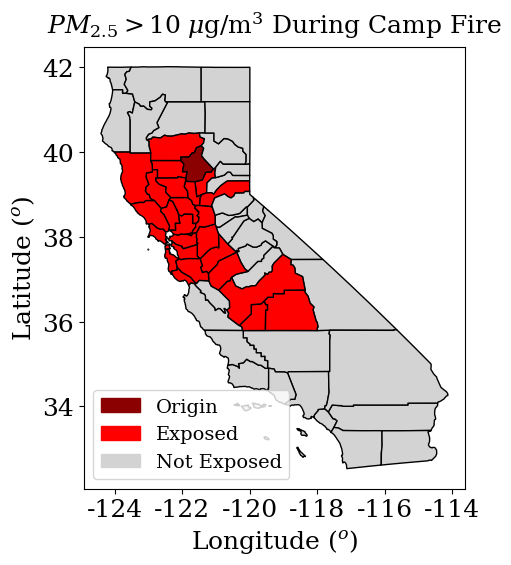

In [12]:
# Load and filter counties
url = "https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json"
counties = gpd.read_file(url)
counties['state'] = counties['id'].str[:2]  # Extract state FIPS code
california_counties = counties[counties['state'] == '06'].reset_index(drop=True)

# Merge with smoke data from exposed_data (assumes exposed_data is already defined)
california_counties = california_counties.merge(
    exposed_data[["countyname", "smoke"]],
    left_on="NAME",
    right_on="countyname"
)

# Convert smoke to binary: 1 if > 10, otherwise 0, then set 0 to np.nan
california_counties["smoke"] = (california_counties["smoke"] > 10) * 1
california_counties.loc[california_counties["smoke"] == 0, "smoke"] = np.nan

# Create a categorical column for plotting:
# For counties with smoke==1, label as "High Smoke"
# For counties with NaN, label as "Missing"
def assign_category(val):
    if np.isnan(val):
        return "Missing"
    else:
        return "High Smoke"

california_counties["smoke_cat"] = california_counties["smoke"].apply(assign_category)
california_counties.loc[california_counties["countyname"] == "Butte", "smoke_cat"] = "Origin"

# Define a mapping for categories to colors.
color_map = {"High Smoke": "red", "Missing": "lightgray", "Origin": "darkred"}

# Create a figure and axis.
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Plot using the manual color mapping.
california_counties.plot(
    color=california_counties["smoke_cat"].map(color_map),
    ax=ax,
    edgecolor="black"
)

ax.set_title(r"$PM_{2.5} > 10\; \mu \mathrm{g}/\mathrm{m}^3$ During Camp Fire", fontsize=18, pad=10)

# Create a custom legend with patches.
patch_high = mpatches.Patch(color="red", label="Exposed")
patch_missing = mpatches.Patch(color="lightgray", label="Not Exposed")
patch_origin = mpatches.Patch(color="darkred", label="Origin")
ax.legend(handles=[patch_origin, patch_high, patch_missing], loc="lower left", fontsize=14)

plt.xlabel(r"Longitude ($^o$)")
plt.xticks([-124, -122, -120, -118, -116, -114], [-124, -122, -120, -118, -116, -114])
plt.ylabel(r"Latitude ($^o$)")
plt.tight_layout()

plt.savefig(os.path.join(figs_dir, "PM2.5_Camp_Fire_Exposed.pdf"), dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(figs_dir, "PM2.5_Camp_Fire_exposed.png"), dpi=200, bbox_inches="tight")

plt.show()

In [13]:
california_counties.loc[~np.isnan(california_counties["smoke"]), "countyname"].values

array(['Glenn', 'Lake', 'Napa', 'Stanislaus', 'Yuba', 'Butte',
       'Mendocino', 'San Francisco', 'Yolo', 'San Mateo', 'Santa Cruz',
       'Solano', 'Sutter', 'Tehama', 'Contra Costa', 'Kings', 'Colusa',
       'Merced', 'San Joaquin', 'Tulare', 'Marin', 'Placer', 'Fresno',
       'Sacramento', 'Alameda', 'Sonoma', 'Santa Clara'], dtype=object)

## 2.4 PM2.5 Interpolated Grid Data

In this section, we illustrate how county-level PM2.5 data can be interpolated onto a latitude-longitude grid. By performing this interpolation, we move from coarser county boundaries to a finer spatial resolution, allowing us to:

- **Capture spatial nuances** of PM2.5 concentrations that might otherwise be overlooked at the county level.
- **Enable more detailed visual and statistical analyses**, such as identifying localized “hot spots” or trends in air pollution.
- **Facilitate integration** with other spatial datasets or geostatistical methods.

Below, we visualize the resulting gridded PM2.5 estimates, providing a clearer picture of how pollutant levels vary across different regions.


In [14]:
# Reset counties dataframe
# Read in california counties geo
url = "https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json"
counties = gpd.read_file(url)
# Filter counties to only include those in California (FIPS code '06')
counties['state'] = counties['id'].str[:2]  # Extract state FIPS code
california_counties = counties[counties['state'] == '06'].reset_index()
california_counties["centroid"] = california_counties.geometry.centroid
california_counties["countyname"] = california_counties["NAME"].str.title()
counties_sindex = california_counties.sindex

C:\Users\anton\AppData\Local\Temp\ipykernel_68448\2329521738.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  california_counties["centroid"] = california_counties.geometry.centroid


In [15]:
# Functions for grid interpolation
grid_res = 0.25
lat_min, lat_max = 32.0, 42.0
lon_min, lon_max = -125.0, -114.0
lats = np.arange(lat_min, lat_max, grid_res)
lons = np.arange(lon_min, lon_max, grid_res)

def get_grid_gdf(grid_res=0.25):
    """Obtains grid geometry"""
    cells = []
    grid_rows = []
    grid_cols = []

    for i, lat in enumerate(lats):
        for j, lon in enumerate(lons):
            # Each cell is a square polygon of size grid_res deg
            # corners: (lon,lat), (lon+grid_res,lat), (lon+grid_res,lat+grid_res), (lon,lat+grid_res)
            poly = geom.Polygon([
                (lon,     lat),
                (lon+grid_res, lat),
                (lon+grid_res, lat+grid_res),
                (lon,     lat+grid_res)
            ])
            cells.append(poly)
            grid_rows.append(i)
            grid_cols.append(j)

    grid_gdf = gpd.GeoDataFrame({
        "grid_row": grid_rows,
        "grid_col": grid_cols,
        "geometry": cells
    }, crs="EPSG:4326")
    grid_gdf["center"] = grid_gdf.geometry.centroid
    return grid_gdf

def get_grid_data(
    data_slice, day_of_year, grid_gdf,
    feature_names=["tmax", "prec", "hum", "shrtwv_rad", "wind", "smoke", "resp", "resp_norm"], 
    grid_res = 0.25):
    
    daily_data = data_slice[data_slice.day_of_year==day_of_year][["countyname"] + feature_names]
    california_counties_daily = california_counties.merge(daily_data, on="countyname")
    grid_gdf_local = grid_gdf.copy(deep=True)
    
    for feat_name in feature_names:
        values = []
        for i, row in grid_gdf.iterrows():
            cell_poly = row.geometry
            cell_center = row["center"]
            
            # 1) Find intersecting counties
            possible_matches_index = list(counties_sindex.intersection(cell_poly.bounds))
            candidates = california_counties_daily.iloc[possible_matches_index]
            intersecting = candidates[candidates.intersects(cell_poly)]
 
            if intersecting.empty:
                # No intersection => NaN
                values.append(np.nan)
                continue

            # 2) For each intersecting county, compute distance from cell_center to county centroid
            w_sum = 0.0
            val_sum = 0.0
            epsilon = 1e-6
            for j, cty in intersecting.iterrows():
                dist = cell_center.distance(cty["centroid"])  # distance in degrees if EPSG:4326
                w = 1.0 / (dist + epsilon)
                w_sum += w
                val_sum += w * cty[feat_name]

            # Weighted average
            cell_value = val_sum / w_sum
            values.append(cell_value)

        grid_gdf[feat_name] = values
        
    num_rows = len(lats)  # from your np.arange
    num_cols = len(lons)

    interp_array = np.full((len(feature_names), num_rows, num_cols), np.nan, dtype=np.float32)

    # Need a quick way to map lat/lon back to row/col indices
    # e.g. row = i, col = j if lat=some lat, lon=some lon

    for i, rowdata in grid_gdf.iterrows():
        # Suppose you stored "grid_row", "grid_col" in the gdf if you created them
        r = rowdata["grid_row"]
        c = rowdata["grid_col"]
        for i, feat_name in enumerate(feature_names):
            interp_array[i, r, c] = rowdata[feat_name]
    return interp_array, ~np.isnan(interp_array[0]) # num_features X H X W and mask

In [16]:
### Example of grid interpolation
grid_res = 0.25
grid_gdf = get_grid_gdf(grid_res=grid_res)
day_of_year = 322
feature_names=["tmax", "prec", "hum", "shrtwv_rad", "wind", "smoke", "resp", "resp_norm"]
interp_array, mask = get_grid_data(data_slice, feature_names=feature_names, day_of_year=day_of_year, 
                                 grid_gdf=grid_gdf, grid_res=grid_res)
post_process_idx_pairs = [
(3, 25), (3, 26),
(4, 21), (4, 22), (4, 25),
(5, 21), (5, 22), (5, 25), (5, 26),
(7, 19), (7, 20), (7, 21),
(8, 18), (8, 19), (8, 20), (8, 21),
(22, 7), (22, 8), (23, 7)
]
for pair in post_process_idx_pairs:
    interp_array[:, pair[0], pair[1]] = np.nan

C:\Users\anton\AppData\Local\Temp\ipykernel_68448\4165523541.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf["center"] = grid_gdf.geometry.centroid


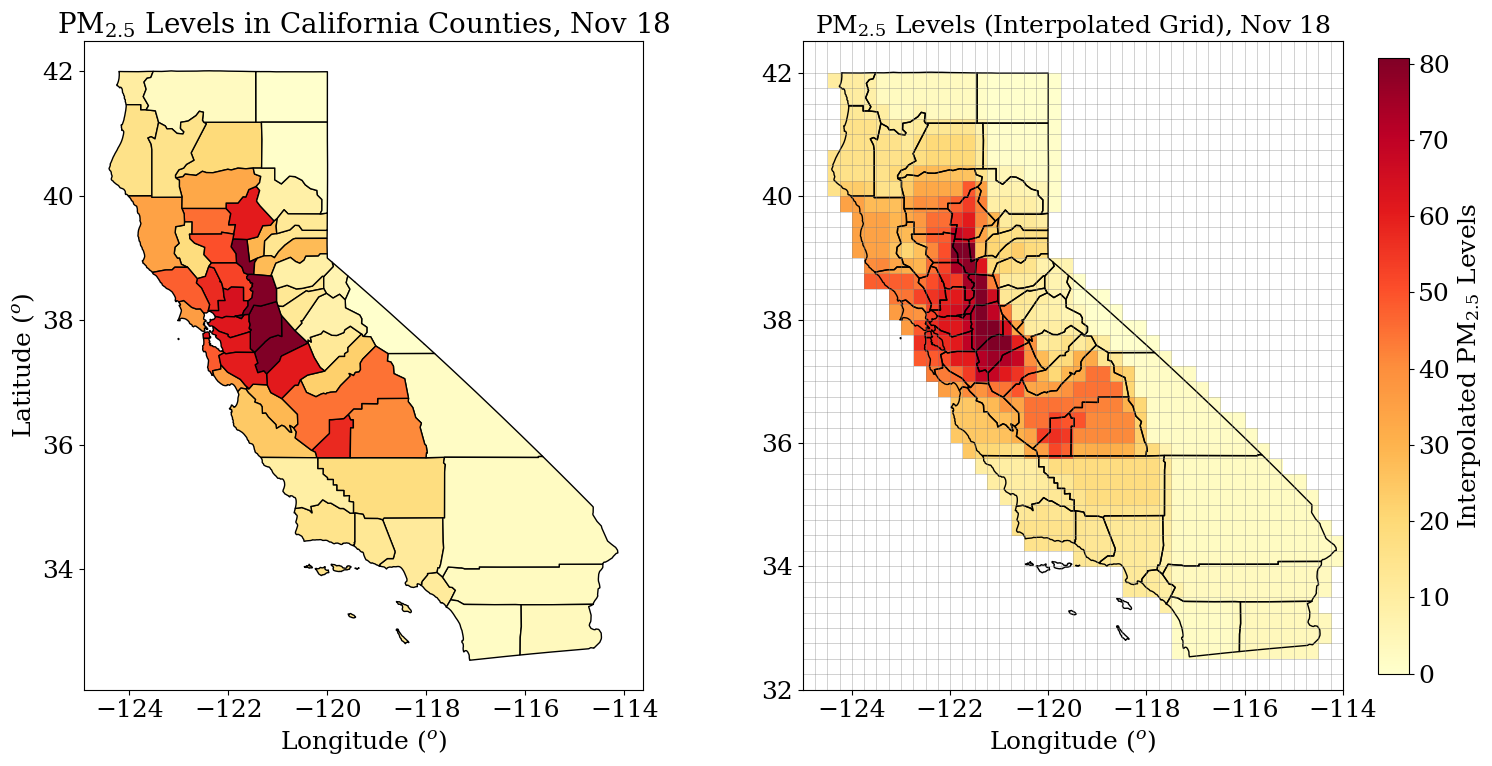

In [17]:
daily_data = data_slice[data_slice.day_of_year==day_of_year][["countyname"] + feature_names]
california_counties_daily = california_counties.merge(daily_data, on="countyname")

# Simulated data for the example
lats = np.arange(lat_min, lat_max + grid_res, grid_res)
lons = np.arange(lon_min, lon_max + grid_res, grid_res)
feat_name = "smoke"
vmin = california_counties_daily[feat_name].min()
vmax = np.percentile(california_counties_daily[feat_name], 95)

# Create the side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: California counties with a color gradient
california_counties_daily.plot(
    column=feat_name, 
    ax=axes[0], 
    #legend=True, 
    cmap='YlOrRd', 
    edgecolor='black',
    vmin=vmin, 
    vmax=vmax
)
axes[0].set_title(r"PM$_{2.5}$ Levels in California Counties, Nov 18", fontsize=20)


# Plot 2: Interpolated grid data with county boundaries
im = axes[1].imshow(
    interp_array[np.argwhere(np.array(feature_names)==feat_name)[0][0]], 
    extent=[lon_min, lon_max, lat_min, lat_max], 
    origin="lower", 
    cmap='YlOrRd',
    vmin=vmin, 
    vmax=vmax
)
california_counties_daily.plot(ax=axes[1], edgecolor='black', facecolor='none')
for lat in np.arange(lat_min, lat_max + grid_res, grid_res):
    axes[1].axhline(y=lat, color='gray', alpha=0.5, lw=0.5)
for lon in np.arange(lon_min, lon_max + grid_res, grid_res):
    axes[1].axvline(x=lon, color="gray", alpha=0.5, lw=0.5)

# Add a shared colorbar for the imshow plot
cbar = fig.colorbar(im, ax=axes[1], shrink=0.95)
cbar.set_label(r"Interpolated PM$_{2.5}$ Levels", fontsize=18)

axes[1].set_title(r"PM$_{2.5}$ Levels (Interpolated Grid), Nov 18", fontsize=18)

# Display the plots
axes[0].set_ylabel(r"Latitude ($^o$)")
axes[0].set_xlabel(r"Longitude ($^o$)")
axes[1].set_xlabel(r"Longitude ($^o$)")
plt.tight_layout()
plt.savefig(os.path.join(figs_dir, "PM2.5_Grid.pdf"), dpi=200, bbox_inches="tight")
plt.savefig(os.path.join(figs_dir, "PM2.5_Grid.png"), dpi=200, bbox_inches="tight")
plt.show()